In [1]:
import warnings
warnings.filterwarnings('ignore')

이제는 sequence 별 공의 움직임을 직접 애니메이션 시각화를 통해 나타내봅니다.\
\
직접적인 애니메이션 효과로 공의 운동 궤적이나 경기의 흐름을 더욱 효과적으로 파악할 수 있습니다.

##### 해당 시각화는 반드시 jupyer notebook에서 실행해야 합니다.

In [2]:
import pandas as pd

# jupyer notebook에는 mysql이 설치되지 않아 EDA가 모두 끝난 미리 저장된 파일을 불러왔습니다.
ball_df = pd.read_csv('ball_df.csv')
sequence_df = pd.read_csv('sequence_df.csv')
events_df = pd.read_csv('events_df.csv')

<IPython.core.display.Javascript object>


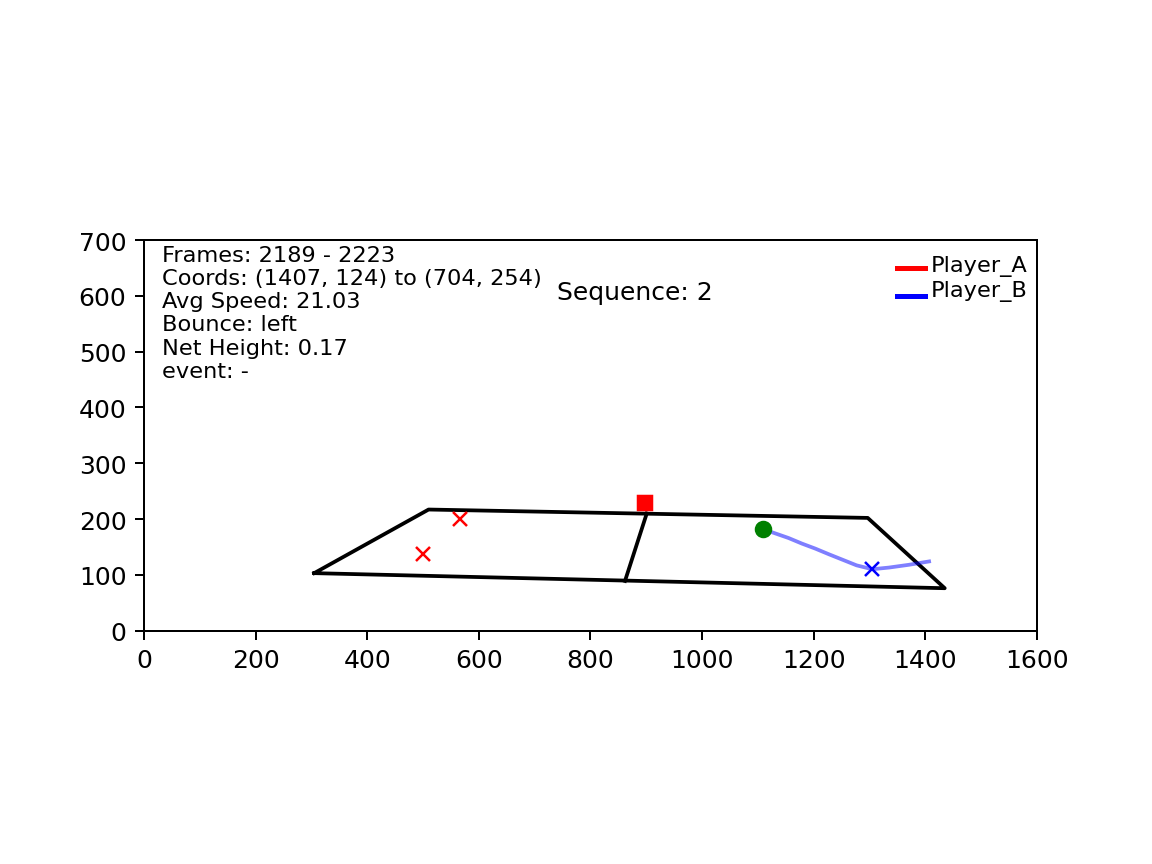

In [3]:
# jupyer notebook에서 시각화 애니메이션이 가능하게 해줍니다. (vscode에서는 불가능)
%matplotlib notebook

import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pandas as pd
import numpy as np


# 테이블과 네트 좌표
table_corners = {'left_bottom': (305, 103),
                 'left_top': (510, 217),
                 'right_top': (1297, 202),
                 'right_bottom': (1435, 76)}
net_coords = [(901, 210), (862, 89)]


# 시각화 함수 정의
def animate_table_tennis(ball_df, sequence_df, events_df, sequence_range, table_corners, net_coords):
    # Filter ball_df and events_df for the given sequence range
    sequence_filter = sequence_df['sequence'].between(*sequence_range)
    sequences = sequence_df[sequence_filter]['sequence']
    ball_df_filtered = ball_df[ball_df['sequence'].isin(sequences)]
    events_df_filtered = events_df[events_df['frame'].isin(ball_df_filtered['frame'])]

    # Subpot 셋업
    fig, ax = plt.subplots()
    ax.set_xlim(0, 1600)
    ax.set_ylim(0, 700)
    ax.set_aspect('equal', adjustable='box')

    # 테이블 그리기
    table_x = [table_corners['left_bottom'][0], table_corners['left_top'][0],
               table_corners['right_top'][0], table_corners['right_bottom'][0],
               table_corners['left_bottom'][0]]
    table_y = [table_corners['left_bottom'][1], table_corners['left_top'][1],
               table_corners['right_top'][1], table_corners['right_bottom'][1],
               table_corners['left_bottom'][1]]
    ax.plot(table_x, table_y, 'k-')

    # 네트 그리기
    net_x, net_y = zip(*net_coords)
    ax.plot(net_x, net_y, 'k-')
     
    # Player_A와 Player_B 색상 정보 추가
    ax.plot([1350, 1400], [650, 650], 'r-', lw=2)  # Player A 빨간색 선
    ax.text(1410, 645, 'Player_A', fontsize=9, color='black')
    ax.plot([1350, 1400], [600, 600], 'b-', lw=2)  # Player B 파란색 선
    ax.text(1410, 600, 'Player_B', fontsize=9, color='black')  
    
    # 선수 별로 공이 움직이면 공 뒤로 생성될 라인의 path를 준비
    path_A, = ax.plot([], [], 'r-', alpha=0.5)  # Player A path
    path_B, = ax.plot([], [], 'b-', alpha=0.5)  # Player B path

    # Ball 마커
    ball_marker, = ax.plot([], [], 'go')  # Ball

    # 각 플레이어별 이벤트 마커 그리기
    bounce_points_A, = ax.plot([], [], 'rx')  # Player A의 bounce 이벤트
    net_points_A, = ax.plot([], [], 'rs')  # Player A의 net 이벤트
    bounce_points_B, = ax.plot([], [], 'bx')  # Player B의 bounce 이벤트
    net_points_B, = ax.plot([], [], 'bs')  # Player B의 net 이벤트


    # sequence 정보 및 시각화 title을 위한 텍스트 객체 추가
    seq_info_text = ax.text(0.02, 0.65, '', transform=ax.transAxes, fontsize=9, color='black')
    title_text = ax.text(0.55, 0.85, '', transform=ax.transAxes, fontsize=10, ha='center', color='black')
    
    # sequence 별로 시각화를 업데이트 해주는 함수
    def update(frame_index):
        frame = ball_df_filtered.iloc[frame_index]
        current_sequence = frame['sequence']
        df_sequence = ball_df_filtered[ball_df_filtered['sequence'] == current_sequence]
        sequence_info = sequence_df[sequence_df['sequence'] == current_sequence].iloc[0]

        # 현재 sequence에 해당하는 events_df_filtered 생성 (설정 여기서 따로 안하면 밑에랑 꼬인다.)
        events_df_sequence = events_df[events_df['frame'].isin(df_sequence['frame'])]

        # frame 구간범위, 좌표 구간범위, 평균속도 정보 추출
        frame_info = f'Frames: {sequence_info["frame_1"]} - {sequence_info["frame_2"]}'
        coord_info = f'Coords: ({sequence_info["x1"]}, {sequence_info["y1"]}) to ({sequence_info["x2"]}, {sequence_info["y2"]})'
        avg_speed_info = f'Avg Speed: {sequence_info["avg_velocity"]:.2f}'

        # Bounce 정보 추출 및 업데이트
        bounce_events = events_df_sequence[events_df_sequence['event'] == 'bounce']
        bounce_info = 'Bounce: '
        if not bounce_events.empty:
            # 모든 bounce 이벤트의 위치를 쉼표로 구분하여 표시
            bounce_info += ', '.join(bounce_events['bounce'].dropna())
        else:
            bounce_info += 'None'

        # Net 넘어갈시 공의 높이 정보 추출 및 업데이트
        net_events = events_df_sequence[events_df_sequence['event'] == 'net']
        if not net_events.empty:
            net_info = 'Net Height: ' + ', '.join(net_events['height'].dropna().apply(lambda x: f'{x:.2f}').unique())
        else:
            net_info = 'Net Height: None'
            
        # net_hit, sub 이벤트 추가 업데이트
        event_text = "event: "
        if sequence_info['net_hit'] == 1:
            event_text += "Net_hit"
        elif sequence_info['sub'] == 1:
            event_text += "Sub"
        else:
            event_text += "-"

        # sequence 정보들 전체 업데이트
        seq_info_text.set_text(f'{frame_info}\n{coord_info}\n{avg_speed_info}\n{bounce_info}\n{net_info}\n{event_text}')
        
        # 시각화 title 업데이트
        title_text.set_text(f'Sequence: {current_sequence}')
        
        
        # 현재 sequence 내에서 현재 frame까지의 위치를 찾기
        current_index_within_sequence = df_sequence.index.get_loc(frame.name)

        # 다음 sequence로 넘어갈 때 이전 sequence의 경로를 초기화 (전 sequence에서 공의 궤적을 따라 그려준 선을 삭제)
        if current_index_within_sequence == 0:
            path_A.set_data([], [])
            path_B.set_data([], [])

        # 플레이어 별로 공의 경로를 실시간으로 업데이트
        df_sequence_A = df_sequence[df_sequence['player'] == 'player_A']
        df_sequence_B = df_sequence[df_sequence['player'] == 'player_B']
        if not df_sequence_A.empty:
            path_A.set_data(df_sequence_A['x'][:current_index_within_sequence+1], df_sequence_A['y'][:current_index_within_sequence+1])
        if not df_sequence_B.empty:
            path_B.set_data(df_sequence_B['x'][:current_index_within_sequence+1], df_sequence_B['y'][:current_index_within_sequence+1])

        # 볼 마커 업데이트
        ball_marker.set_data(frame['x'], frame['y'])

        # 각 플레이어별 이벤트 마커 업데이트 (이벤트 마커는 다음 sequence로 넘어가도 그대로 남아 누적되게 한다. (경로 초기화x) -> 실시간 bounce 정보 파악 가능)
        df_events = events_df_filtered[events_df_filtered['frame'] <= frame['frame']]
        df_events_A = df_events[df_events['player'] == 'player_A']
        df_events_B = df_events[df_events['player'] == 'player_B']
        bounce_points_A.set_data(df_events_A[df_events_A['event'] == 'bounce']['x'], df_events_A[df_events_A['event'] == 'bounce']['y'])
        net_points_A.set_data(df_events_A[df_events_A['event'] == 'net']['x'], df_events_A[df_events_A['event'] == 'net']['y'])
        bounce_points_B.set_data(df_events_B[df_events_B['event'] == 'bounce']['x'], df_events_B[df_events_B['event'] == 'bounce']['y'])
        net_points_B.set_data(df_events_B[df_events_B['event'] == 'net']['x'], df_events_B[df_events_B['event'] == 'net']['y'])

        return path_A, path_B, ball_marker, bounce_points_A, net_points_A, bounce_points_B, net_points_B, seq_info_text, title_text


    # 애니메이션을 생성하여 변수로 저장 (interval로 애니메이션 속도를 조절)
    ani = animation.FuncAnimation(fig, update, frames=len(ball_df_filtered), interval=100, blit=False)

    return ani


# 시각화할 sequence 범위 설정
sequence_range = (1,10)  # 원하는 범위로 조정

# 시각화 실행
ani = animate_table_tennis(ball_df, sequence_df, events_df, sequence_range, table_corners, net_coords)

plt.show()

해당 애니메이션을 동영상 파일로 저장합니다.

In [4]:
# FFmpeg Writer 설정
Writer = animation.writers['ffmpeg']
writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)

# 동영상 파일로 저장
ani.save('game_1.sequence_1_10.mp4', writer=writer)
